# Data Cleaning

In [2]:
'''
Import required packages and libraries for data exploration
'''
import pandas as pd

In [6]:
'''
Set up file path and data handling objects
'''
PATH = "../data/reviews.csv"
data = pd.read_csv(PATH)

## Remove Irrelevant Data Points
The first stage of data cleaning is to identify and remove data points that aren't related to our task. In "Amazon Fine Food Reviews", we have many different product reviews including: pet food, medicine, microwavable food, fine foods, etc.
- Is this category of food or type of review relevant to our task?
- Would removing this type of review from the data improve the accuracy of our model?
- If we remove this type of review, how will it effect our training process (would there be too little data remaining?)

## Remove Uncecessary Columns
- What columns are necessary for our model? 
- Is there anything that needs to be removed?

## Case Sensitivity
Convert the input features in the raw dataset into a case insensitive format (all lowercase/uppercase) to reduce the amount of distinct words in the data.

In [8]:
# Convert text features to lowercase
data['Summary'] = data['Summary'].str.lower()
data['Text'] = data['Text'].str.lower()

# Verify the conversion
print("Sample of converted Summary:")
print(data['Summary'].head())
print("\nSample of converted Text:")
print(data['Text'].head())

Sample of converted Summary:
0    good quality dog food
1        not as advertised
2    "delight" says it all
3           cough medicine
4              great taffy
Name: Summary, dtype: object

Sample of converted Text:
0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price.  there was a wid...
Name: Text, dtype: object


## Remove Filler Words
Some words like "I", "the", "a", etc. don't impact the sentiment of the text content. Remove these words from all review content so there is less redundant features for the final model.

In [14]:
import nltk
from nltk.corpus import stopwords    

print("Downloading NLTK stopwords...")
nltk.download('stopwords', quiet=True)
    
stop_words = set(stopwords.words('english'))

# Print sample of stopwords
print("\nSample of English stopwords:")
print(sorted(list(stop_words))[:10])  # Print first 10 stopwords

def remove_stopwords_from_text(text):
    if pd.isna(text):
        return text
    words = text.lower().split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Process both columns
print("Removing stop words from Summary...")
data['Summary'] = data['Summary'].apply(remove_stopwords_from_text)

print("Removing stop words from Text...")
data['Text'] = data['Text'].apply(remove_stopwords_from_text)

# Print samples for verification
print("\nSample of processed Summary:")
print(data['Summary'].head())
print("\nSample of processed Text:")
print(data['Text'].head())
    


Sample of English stopwords:
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']
Removing stop words from Summary...
Removing stop words from Text...

Sample of processed Summary:
0    good quality dog food
1               advertised
2           "delight" says
3           cough medicine
4              great taffy
Name: Summary, dtype: object

Sample of processed Text:
0    bought several vitality canned dog food produc...
1    product arrived labeled jumbo salted peanuts.....
2    confection around centuries. light, pillowy ci...
3    looking secret ingredient robitussin believe f...
4    great taffy great price. wide assortment yummy...
Name: Text, dtype: object


## Remove HTML marks
Removing unnecessary HTML marks (e.g., "<>,http")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q beautifulsoup4 lxml
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/cleaned_dataset.csv')

import pandas as pd
from bs4 import BeautifulSoup

def remove_html(s: str) -> str:
    return BeautifulSoup(str(s), "lxml").get_text(separator=" ")

input_path = '/content/drive/MyDrive/Colab Notebooks/archive/cleaned_dataset.csv'
df = pd.read_csv(input_path)

for col in ['Summary', 'Text']:
    df[col] = df[col].fillna('').apply(remove_html)

output_path = '/content/drive/MyDrive/Colab Notebooks/archive/html_stripped_full.csv'
df.to_csv(output_path, index=False)


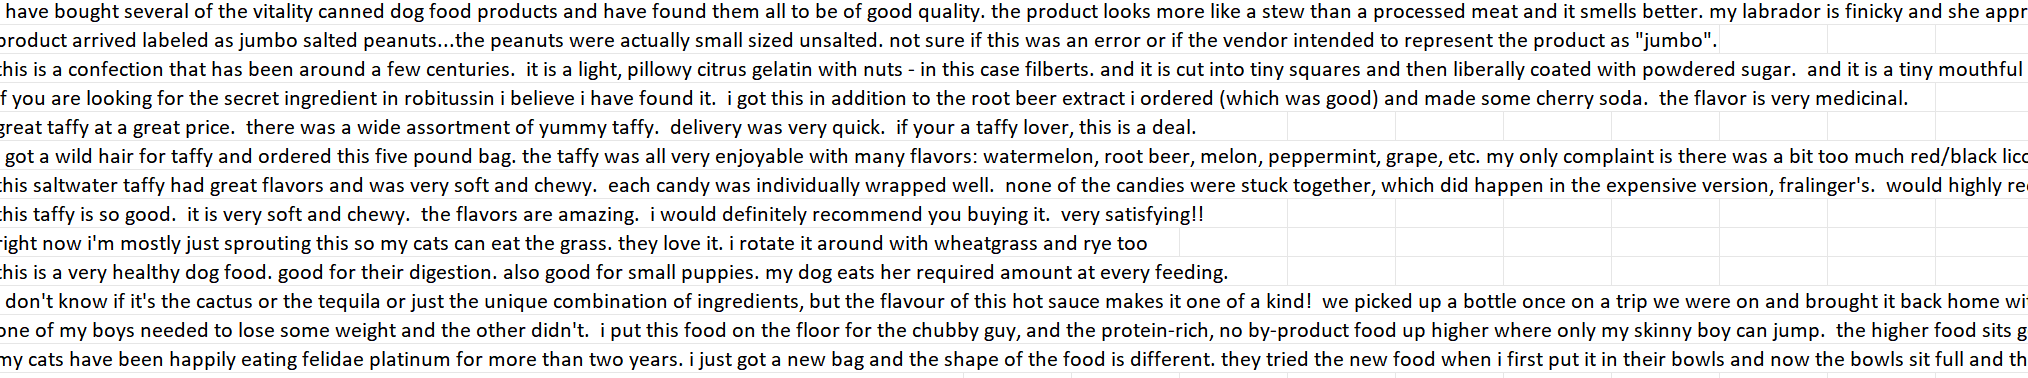

## Punctuation Handling
Some words that contain punctuation can be recorded as separate features without punctuation handling (e.g., "Steve's pizza is great!" and "Steve makes great pizza!").

| is | great | great! | makes | pizza | pizza! | Steve | Steve's |
|----|-------|--------|-------|-------|--------|-------|---------|
|1   | 1     | 1      | 1     | 1     | 1      | 1     | 1       |

We want to remove uncessesary punctuation so that we don't have duplicates of effectively the same word.
| is | great | makes | pizza | Steve |
|----|-------|-------|-------|-------|
| 1  | 2     | 1     | 2     | 2     |

Doing this prevents our model from interpreting duplicate words as two separate features and reduces the number of dimensions our model has to process (increasing efficiency).

In [15]:
import string
import re
    
# Function to remove punctuation from text
def clean_text(text):
    if pd.isna(text):
        return text
    
    # Remove other punctuation
    text = ''.join(char for char in text if char not in string.punctuation)
    
    # Handle multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()
    
# Process both columns
print("Removing punctuation from Summary...")
data['Summary'] = data['Summary'].apply(clean_text)

print("Removing punctuation from Text...")
data['Text'] = data['Text'].apply(clean_text)

    # Print samples for verification
print("\nSample of processed Summary:")
print(data['Summary'].head())
print("\nSample of processed Text:")
print(data['Text'].head())

Removing punctuation from Summary...
Removing punctuation from Text...

Sample of processed Summary:
0    good quality dog food
1               advertised
2             delight says
3           cough medicine
4              great taffy
Name: Summary, dtype: object

Sample of processed Text:
0    bought several vitality canned dog food produc...
1    product arrived labeled jumbo salted peanutsth...
2    confection around centuries light pillowy citr...
3    looking secret ingredient robitussin believe f...
4    great taffy great price wide assortment yummy ...
Name: Text, dtype: object


## Dependency Parsing Split
In this section we need to split the dataset into single entity and multiple entity data points. This step is necessary because the framework for our model requires that single entity data points are handled by **model A** and multiple entity data points are handled by **model B**.

In [ ]:
import pandas as pd

import spacy
from spacy.matcher import PhraseMatcher
import multiprocessing as mp
from tqdm import tqdm
import time


def create_aspect_patterns(nlp):
    food_aspects = {
        'taste': [
            'taste', 'flavor', 'flavour', 'delicious', 'yummy', 'tasty', 'sweet', 'sour', 'bitter', 'spicy',
            'savory', 'savoury', 'tangy', 'zesty', 'bland', 'flavorless', 'tasteless', 'seasoned', 'seasoning',
            'aroma', 'fragrant', 'pungent', 'mild', 'strong', 'rich', 'subtle', 'intense', 'overpowering'
        ],
        'delivery': [
            'delivery', 'shipping', 'arrived', 'packed', 'package', 'ship', 'deliver', 'transit', 'shipped',
            'received', 'arrival', 'dispatch', 'tracking', 'courier', 'postage', 'mail', 'express', 'standard',
            'overnight', 'next day', 'same day', 'delivery time', 'shipping time', 'arrival time'
        ],
        'quality': [
            'quality', 'fresh', 'freshness', 'premium', 'organic', 'natural', 'authentic', 'genuine', 'pure',
            'high quality', 'low quality', 'inferior', 'superior', 'excellent', 'poor', 'grade', 'standard',
            'artisanal', 'handmade', 'crafted', 'processed', 'preserved', 'artificial', 'synthetic', 'chemical'
        ],
        'price': [
            'price', 'cost', 'expensive', 'cheap', 'affordable', 'value', 'worth', 'budget', 'economical',
            'overpriced', 'underpriced', 'reasonable', 'unreasonable', 'discount', 'sale', 'deal', 'bargain',
            'premium', 'luxury', 'budget-friendly', 'cost-effective', 'pricey', 'price point', 'price range'
        ],
        'packaging': [
            'packaging', 'container', 'box', 'seal', 'wrapped', 'packed', 'sealed', 'vacuum', 'airtight',
            'resealable', 'leakproof', 'spillproof', 'fragile', 'damaged', 'broken', 'intact', 'secure',
            'presentation', 'presented', 'wrapped', 'unwrapped', 'opened', 'closed', 'lid', 'cap', 'seal'
        ],
        'service': [
            'service', 'customer service', 'support', 'help', 'response', 'assistance', 'staff', 'representative',
            'agent', 'helpful', 'unhelpful', 'responsive', 'unresponsive', 'friendly', 'unfriendly', 'professional',
            'unprofessional', 'attentive', 'inattentive', 'efficient', 'inefficient', 'satisfactory', 'unsatisfactory'
        ],
        'texture': [
            'texture', 'crunchy', 'soft', 'hard', 'smooth', 'creamy', 'crispy', 'chewy', 'tender', 'tough',
            'moist', 'dry', 'juicy', 'watery', 'thick', 'thin', 'grainy', 'gritty', 'sandy', 'powdery',
            'flaky', 'crumbly', 'dense', 'light', 'airy', 'spongy', 'rubbery', 'gelatinous', 'sticky', 'gooey'
        ],
        'appearance': [
            'appearance', 'look', 'color', 'colour', 'shape', 'size', 'presentation', 'presented', 'visual',
            'attractive', 'unattractive', 'appealing', 'unappealing', 'beautiful', 'ugly', 'perfect', 'imperfect',
            'uniform', 'inconsistent', 'consistent', 'varied', 'variety', 'selection', 'assortment', 'arrangement'
        ],
        'health': [
            'healthy', 'unhealthy', 'nutrition', 'nutritious', 'calorie', 'calories', 'diet', 'dietary',
            'organic', 'natural', 'artificial', 'preservative', 'additive', 'ingredient', 'allergen', 'allergy',
            'gluten', 'dairy', 'vegan', 'vegetarian', 'kosher', 'halal', 'sugar', 'fat', 'protein', 'fiber',
            'vitamin', 'mineral', 'nutrient', 'benefit', 'harmful', 'safe', 'unsafe'
        ],
        'shelf_life': [
            'expiry', 'expiration', 'expired', 'fresh', 'stale', 'spoiled', 'rotten', 'moldy', 'mouldy',
            'shelf life', 'storage', 'stored', 'preserve', 'preserved', 'last', 'lasts', 'durability',
            'durable', 'perishable', 'non-perishable', 'long-lasting', 'short-lived', 'best before', 'use by'
        ],
        'portion': [
            'portion', 'serving', 'size', 'amount', 'quantity', 'adequate', 'inadequate', 'sufficient',
            'insufficient', 'generous', 'small', 'large', 'enough', 'not enough', 'plenty', 'scant',
            'satisfying', 'unsatisfying', 'filling', 'not filling', 'substantial', 'meager', 'ample'
        ],
        'preparation': [
            'prepare', 'preparation', 'cook', 'cooking', 'heat', 'heated', 'microwave', 'oven', 'stove',
            'ready', 'ready-to-eat', 'instant', 'quick', 'easy', 'difficult', 'convenient', 'inconvenient',
            'time-consuming', 'effortless', 'simple', 'complex', 'instructions', 'directions', 'recipe'
        ]
    }
    matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
    patterns = []
    
    for aspect, keywords in food_aspects.items():
        patterns.extend([nlp(text) for text in keywords])
        matcher.add(aspect, patterns)
        patterns = []  # Reset patterns for next aspect
        
    return matcher

def count_aspects_batch(texts, nlp, matcher):
    # Filter out None/NaN values
    valid_texts = [str(text) for text in texts if pd.notna(text)]
    if not valid_texts:
        return [0] * len(texts)
    
    # Process texts in batch using spaCy's pipe
    docs = list(nlp.pipe(valid_texts, batch_size=len(texts)))
    
    # Count aspects for each document
    counts = []
    doc_idx = 0
    for text in texts:
        if pd.isna(text):
            counts.append(0)
        else:
            doc = docs[doc_idx]
            matches = matcher(doc)
            aspects_found = set()
            for match_id, start, end in matches:
                aspects_found.add(nlp.vocab.strings[match_id])
            counts.append(len(aspects_found))
            doc_idx += 1
    
    return counts


spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")
matcher = create_aspect_patterns(nlp)

batch_size = 2000
total_batches = (len(data) + batch_size - 1) // batch_size


# Process in batches
start_time = time.time()

# Process Summary column
print("\nProcessing Summary field...")
summary_counts = []
with tqdm(total=total_batches, desc="Summary batches") as pbar:
    for i in range(0, len(data), batch_size):
        batch = data['Summary'].iloc[i:i+batch_size]
        counts = count_aspects_batch(batch, nlp, matcher)
        summary_counts.extend(counts)
        pbar.update(1)

# Process Text column
print("\nProcessing Text field...")
text_counts = []
with tqdm(total=total_batches, desc="Text batches") as pbar:
    for i in range(0, len(data), batch_size):
        batch = data['Text'].iloc[i:i+batch_size]
        counts = count_aspects_batch(batch, nlp, matcher)
        text_counts.extend(counts)
        pbar.update(1)

# Print performance metrics
end_time = time.time()
processing_time = end_time - start_time
print(f"\nProcessing completed in {processing_time:.2f} seconds")
print(f"Average processing speed: {len(data)/processing_time:.2f} reviews/second")

# Add counts to DataFrame
data['summary_aspect_count'] = summary_counts
data['text_aspect_count'] = text_counts

# Split the data
print("\nSplitting data into single and multiple aspect sets...")

# Single aspect: either Summary or Text mentions exactly one aspect
single_aspect_mask = (data['summary_aspect_count'] <= 1) | (data['text_aspect_count'] <= 1)
single_aspect_data = data[single_aspect_mask].copy()

# Multiple aspect: both Summary and Text mention more than one aspect
multiple_aspect_mask = (data['summary_aspect_count'] > 1) & (data['text_aspect_count'] > 1)
multiple_aspect_data = data[multiple_aspect_mask].copy()


# Remove temporary columns before saving
single_aspect_data = single_aspect_data.drop(['summary_aspect_count', 'text_aspect_count'], axis=1)
multiple_aspect_data = multiple_aspect_data.drop(['summary_aspect_count', 'text_aspect_count'], axis=1)

# Save the split datasets
single_entity_file = "../data/reviews_single_aspect.csv"
multiple_entity_file = "../data/reviews_multiple_aspect.csv"
print(f"Saving single aspect data to {single_entity_file}...")
single_aspect_data.to_csv(single_entity_file, index=False)

print(f"Saving multiple aspect data to {multiple_entity_file}...")
multiple_aspect_data.to_csv(multiple_entity_file, index=False)


Processing Summary field...


Summary batches: 100%|██████████| 285/285 [07:02<00:00,  1.48s/it]



Processing Text field...


Text batches:   4%|▍         | 11/285 [02:18<1:00:01, 13.14s/it]

## Word Embedding